## Manually creating twisted bilayers of hBN
The following code attempts to manually create twisted bilayers of hBN using methods from ASE and abTEM.

In [1]:
# Import all necessary packages
%matplotlib inline

import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy
import ase
import abtem
from abtem import show_atoms

In [2]:
print(f'Python version: {sys.version}')
print(f'ASE version: {ase.__version__}')
print(f'Scipy version: {scipy.__version__}')
print(f'abTEM version: {abtem.__version__}')

Python version: 3.11.14 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 18:30:03) [MSC v.1929 64 bit (AMD64)]
ASE version: 3.27.0
Scipy version: 1.17.0
abTEM version: 1.0.9


In [3]:
# Read the cif file for hBN + extend the cell along the x- and y-directions
hBN = ase.io.read('BN.cif', index=-1) * (10, 10, 1)

# The cif file includes two layers of hBN
# 1. Create a mask to extract only one of the layers
# 2. Reduce the vacuum space left behind by masking operation
mask = hBN.get_scaled_positions()[:,2] < 0.5
monolayerhBN = hBN[mask]
monolayerhBN.center(vacuum=-2, axis=2)

# Make sure the supercell is NOT periodic along the z-direction
monolayerhBN.set_pbc([1, 1, 0])
print('PBC for monolayer?')
print(f'x-direction: {monolayerhBN.get_pbc()[0]}')
print(f'y-direction: {monolayerhBN.get_pbc()[1]}')
print(f'z-direction: {monolayerhBN.get_pbc()[2]}')

PBC for monolayer?
x-direction: True
y-direction: True
z-direction: False


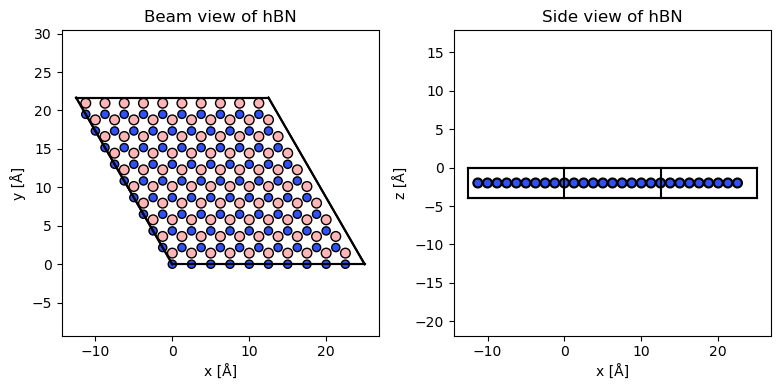

In [4]:
# Visualize monolayer along the beam view and along the side
fig, axs = plt.subplots(1, 2, figsize=(8,4))
show_atoms(monolayerhBN, plane='xy', ax=axs[0])
show_atoms(monolayerhBN, plane='xz', ax=axs[1])

axs[0].set_title('Beam view of hBN')
axs[1].set_title('Side view of hBN')

plt.tight_layout()
plt.show()

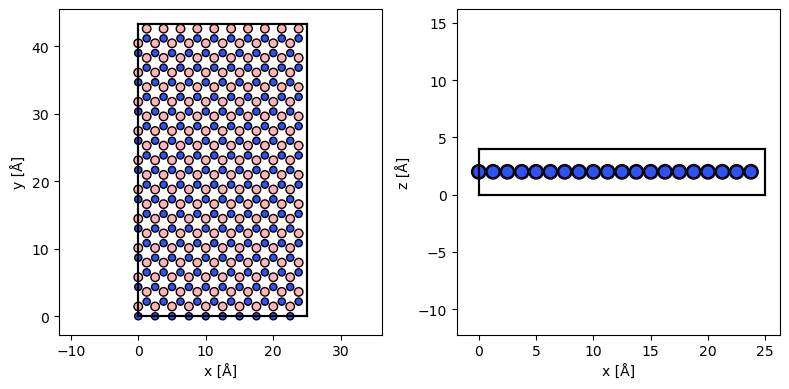

In [5]:
# Orthogonalize the supercell
orthogonal_monolayer = abtem.orthogonalize_cell(monolayerhBN)
fig, axs = plt.subplots(1, 2, figsize=(8,4))
show_atoms(orthogonal_monolayer, plane='xy', ax=axs[0])
show_atoms(orthogonal_monolayer, plane='xz', ax=axs[1])
plt.tight_layout()
plt.show()

In [6]:
# Generate twisted bilayers of hBN
twist_angle = 21.79 # degrees
z_separation = hBN.get_positions()[1,2] - hBN.get_positions()[0,2] # distance (in Angstroms) between layers

z_original = orthogonal_monolayer.get_positions()[0,2] # original z-position of the monolayer
z_original

np.float64(1.9999999999999998)

In [7]:
# Simply twisting the two layers will cause the corners of each layer to protrude without another layer overlapping along them
# This function will crop the supercell so that it only contains regions of the appended structure that overlap.

def crop_center_square(structure, shrink_factor=0.8):
    """
    Crops the supercell of an Atoms object by scaling it down by a user-specified factor.

    Parameters:
        - structure (Atoms object in ASE): Input structure
        - shrink_factor (float): Percent factor that the original structure will be shrunken down to

    Returns:
        - cropped (Atoms object in ASE): Output structure of cropped supercell
    """
    
    cell = structure.get_cell()
    Lx, Ly = cell.lengths()[:2]

    new_Lx = shrink_factor * Lx
    new_Ly = shrink_factor * Ly

    center = np.array([Lx/2, Ly/2])

    pos = structure.get_positions()

    mask = (
        (abs(pos[:,0] - center[0]) <= new_Lx/2) &
        (abs(pos[:,1] - center[1]) <= new_Ly/2)
    )

    cropped = structure[mask].copy()

    cropped.set_cell([
        [new_Lx, 0, 0],
        [0, new_Ly, 0],
        [0, 0, cell[2,2]]
    ])

    cropped.center(axis=(0,1))

    return cropped

In [8]:
full_structure = orthogonal_monolayer.copy()
second_monolayer = orthogonal_monolayer.copy()
vacuum_layer_height = orthogonal_monolayer.get_cell().lengths()[2] / 2
z_offset = z_original + z_separation - vacuum_layer_height # original z-position + distance between monolayers - additional height from vacuum space

second_monolayer.positions[:,2] += z_offset
second_monolayer.euler_rotate(phi=twist_angle/2, center='COU') # twist along the center of the supercell
full_structure.euler_rotate(phi=-twist_angle/2, center='COU')

full_structure.extend(second_monolayer)
full_structure.center(vacuum=2.0, axis=2)
full_structure = crop_center_square(full_structure)
full_structure.wrap()

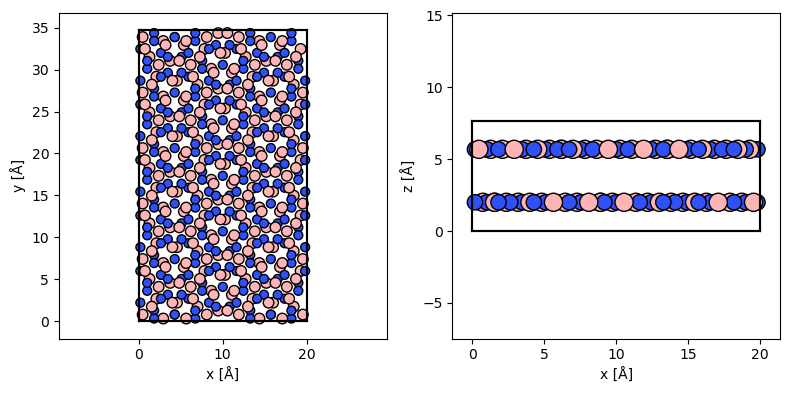

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
show_atoms(full_structure, plane='xy', ax=axs[0])
show_atoms(full_structure, plane='xz', ax=axs[1])
plt.tight_layout()
plt.show()

## Running a custom function for twisted bilayer structure generation
This will run a separate Python script called twisted_bilayers.py, which compiles all of the previous code thus far into a custom function called generate_twisted_bilayers() and calls this function to generate twisted bilayers using CIFs from any 2D material.

In [11]:
# Run the Python script for twisted bilayer structure generation
%run twisted_bilayers.py

Text(0.5, 1.0, 'WSe2')

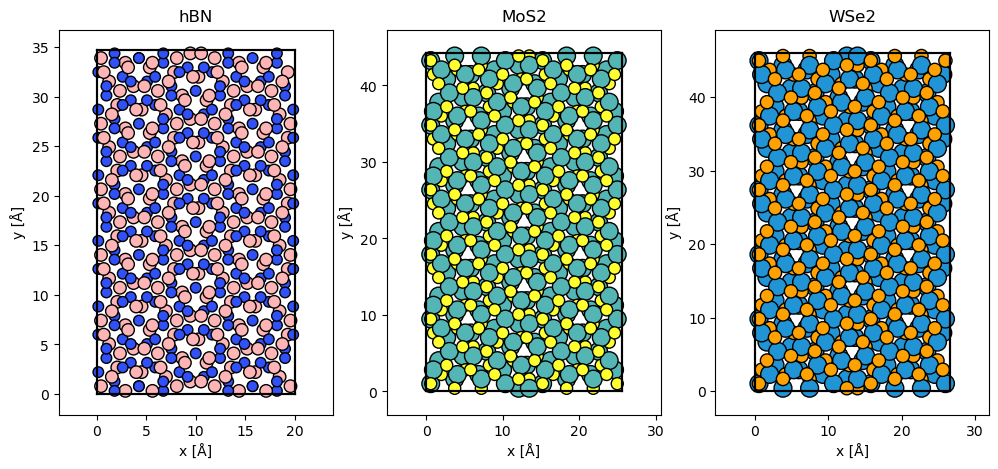

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(12,5))
show_atoms(generate_twisted_bilayers('BN.cif', 21.79), plane='xy', ax=axs[0])
show_atoms(generate_twisted_bilayers('MoS2.cif', 21.79), plane='xy', ax=axs[1])
show_atoms(generate_twisted_bilayers('WSe2.cif', 21.79), plane='xy', ax=axs[2])
axs[0].set_title('hBN')
axs[1].set_title('MoS2')
axs[2].set_title('WSe2')

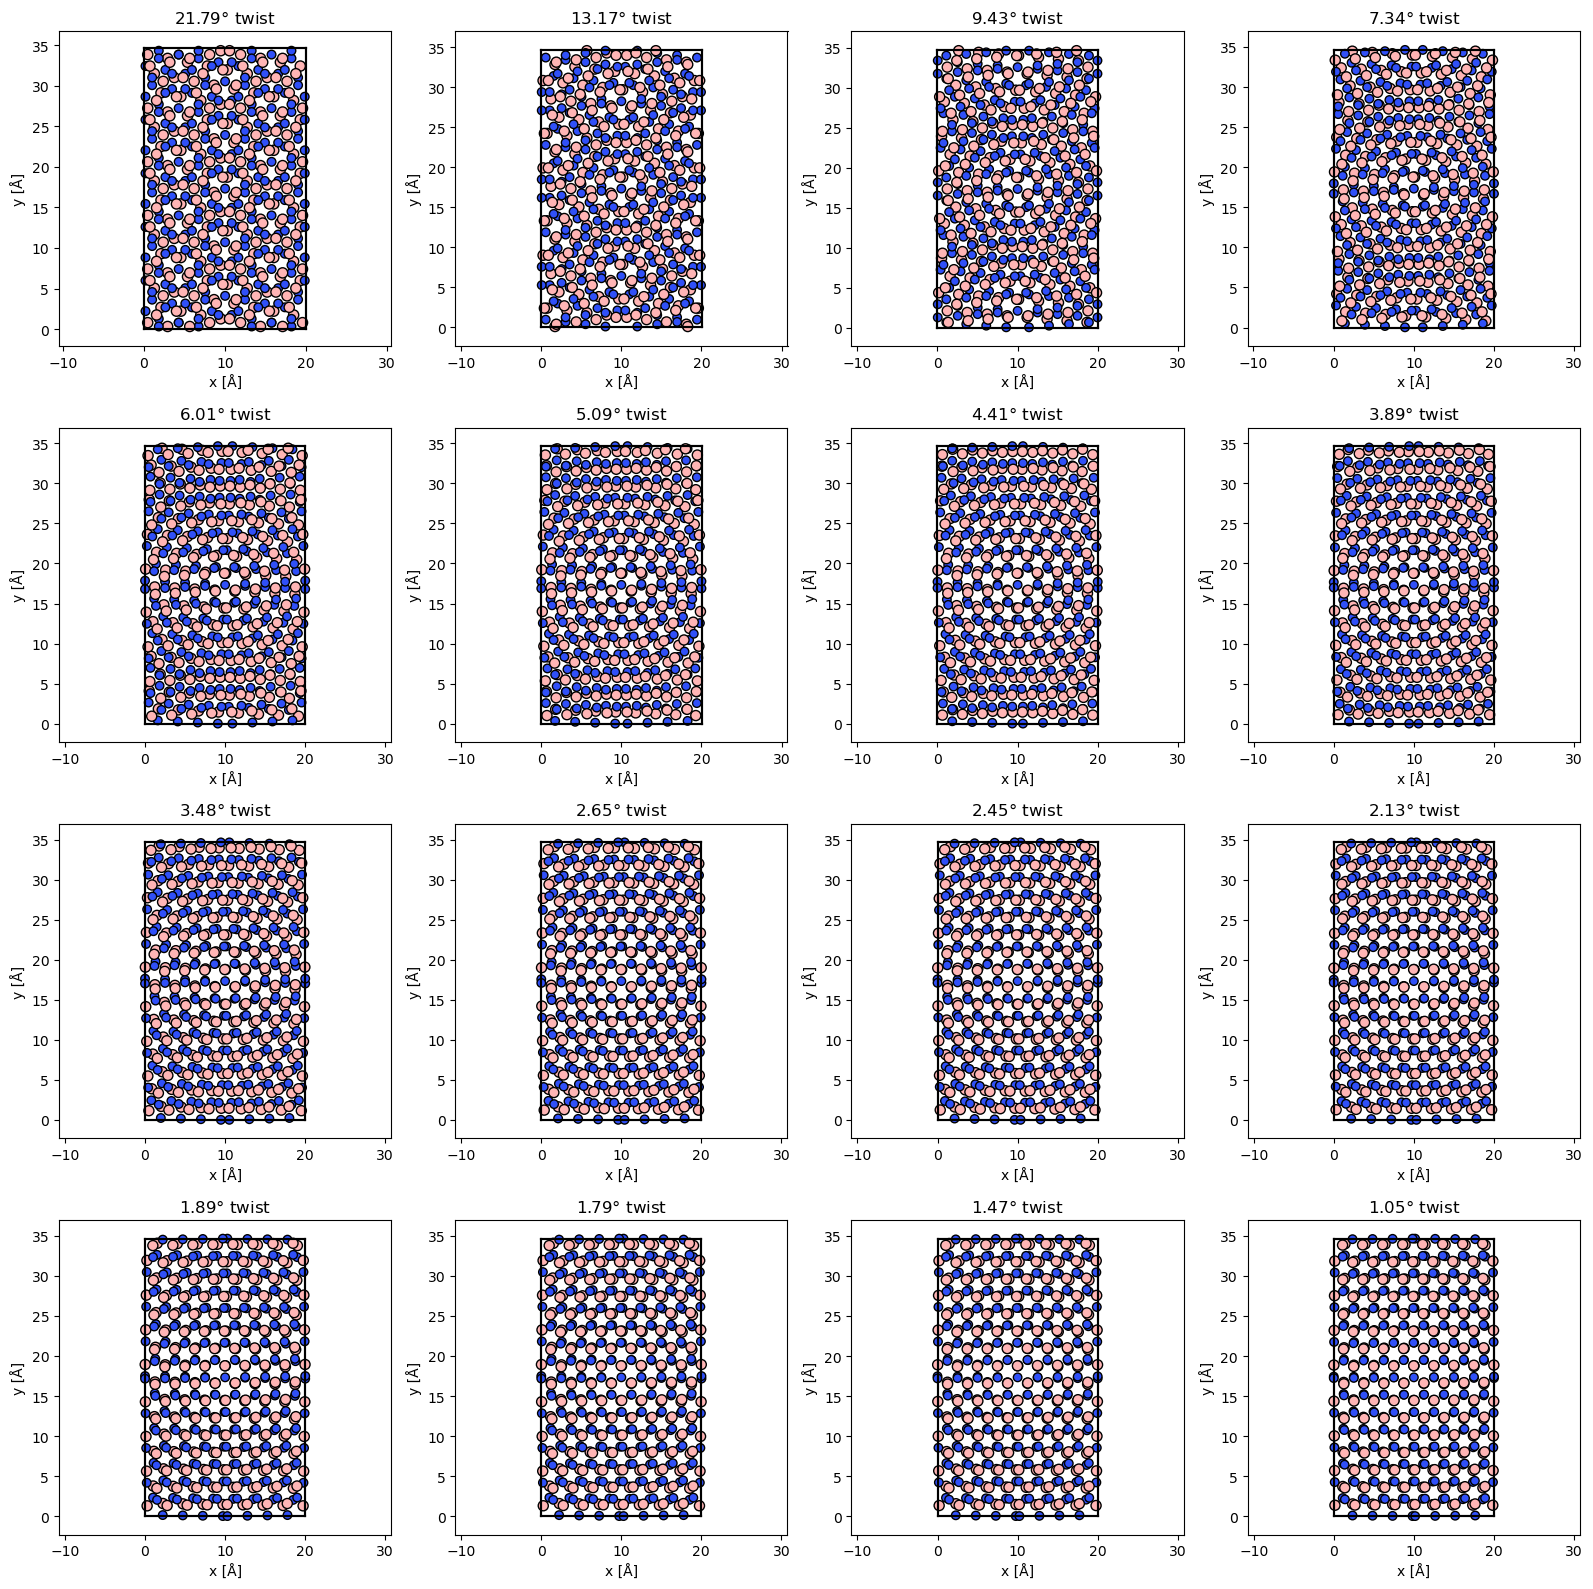

In [13]:
# Known commensurate twist angles
# Source: https://github.com/cubanpit/graphene-bilayer-dft/blob/master/graphene_bilayer_rot.py
commensurate_twist_angles = np.array([21.79, 13.17, 9.43, 7.34, 6.01, 5.09, 4.41, 3.89, 3.48, 2.65, 2.45, 2.13, 1.89, 1.79, 1.47, 1.05])
commensurate_twist_angles = commensurate_twist_angles.reshape((4,4))
fig, axs = plt.subplots(4, 4, figsize=(16,16))

for (i,j), twist in np.ndenumerate(commensurate_twist_angles):
    show_atoms(generate_twisted_bilayers('BN.cif', twist), plane='xy', ax=axs[i,j])
    axs[i,j].set_title(f'{twist}$\degree$ twist')

plt.tight_layout()
plt.show()